In [1]:
import pandas as pd
import numpy as np
import glob
import os, sys
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from tqdm import tqdm
!pip install plotly -q
import plotly.io as pio
#pio.renderers.default = "iframe_connected"
import plotly.express as px
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [2]:
# List of the csv files in the data folder
files=[f for f in os.listdir("sources/") if f.endswith('14.csv')]

In [3]:
files

['uber-raw-data-sep14.csv',
 'uber-raw-data-may14.csv',
 'uber-raw-data-jul14.csv',
 'uber-raw-data-jun14.csv',
 'uber-raw-data-aug14.csv',
 'uber-raw-data-apr14.csv']

In [4]:
#Create of a unique dataframe that concatenates all the csv files
df_list = []
directory = "sources/"

for f in files:
    df_list.append(pd.read_csv(directory+f))

In [5]:
df = pd.concat(df_list)

In [6]:
#We just keep a sample of 10000 observations
df_s = df.sample(n=10000, random_state = 0)

In [7]:
df_s.head()

Date/Time      Lat      Lon    Base
567915  5/20/2014 16:46:00  40.7555 -73.9758  B02682
895170  9/11/2014 12:31:00  40.7552 -73.9674  B02764
454935   5/5/2014 17:43:00  40.7391 -73.9869  B02682
316550    6/9/2014 6:25:00  40.7332 -73.9902  B02617
474563  8/19/2014 20:01:00  40.7200 -73.9885  B02617

In [8]:
#Check of missing values share
print(100*df.isna().sum()/df.shape[0])

Date/Time    0.0
Lat          0.0
Lon          0.0
Base         0.0
dtype: float64


In [9]:
#Data cleaning and addition of day_of_week and time_hour
df_s.rename(columns={"Date/Time": "date"}, inplace=True)
df_s["date"]= pd.to_datetime(df_s["date"])
df_s['day_of_week'] = df_s['date'].dt.dayofweek
df_s['time_hour'] = df_s['date'].dt.hour
df_s.drop(["date"], axis = 1, inplace = True)
df_s.drop(["Base"], axis = 1, inplace = True)

In [10]:
#Standard scaling
df_clustering = df_s
sc = StandardScaler()
df_clustering = sc.fit_transform(df_clustering)

### 1 - Kmeans method

In [11]:
wcss =  []
k = []
for i in tqdm(range (1,20), colour = "green"): 
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(df_clustering)
    wcss.append(kmeans.inertia_)
    k.append(i)

100%|██████████| 19/19 [00:28<00:00,  1.52s/it]


In [12]:
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)
fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)
fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)
fig.show(renderer="iframe")

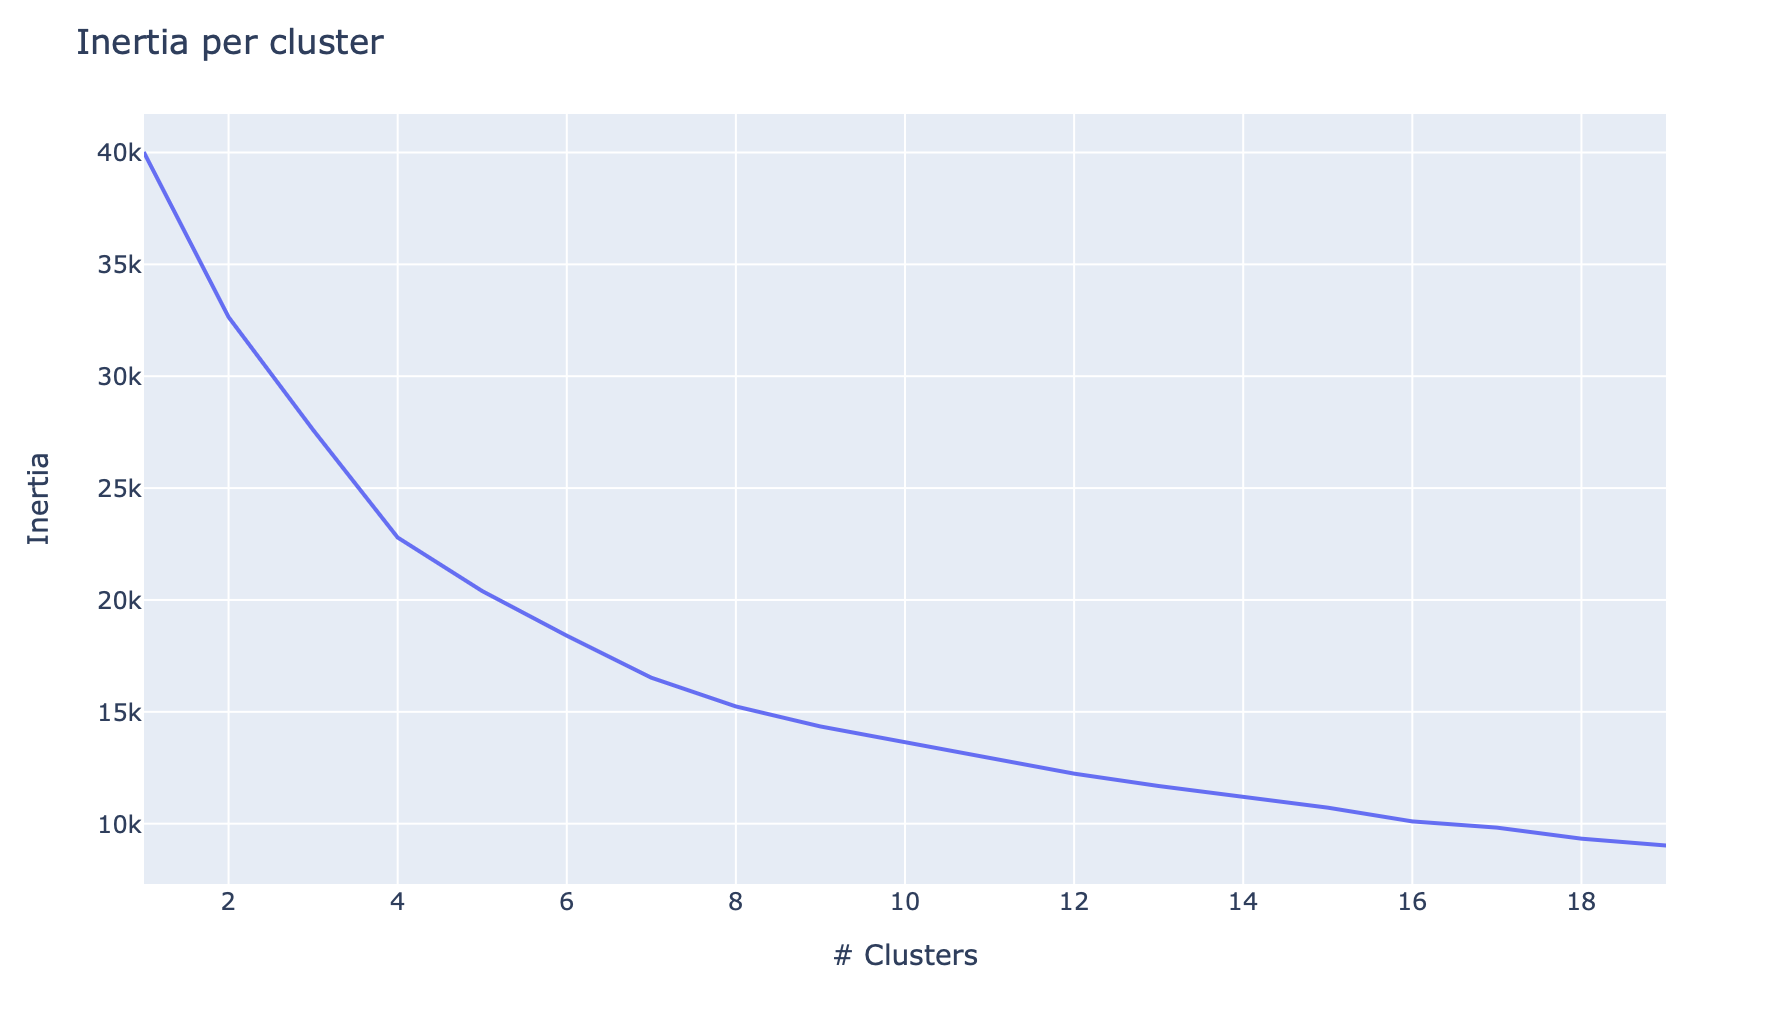

In [13]:
from IPython.display import display, Image
display(Image(filename='img/1.png'))

In [14]:
sil = []
k = []
for i in tqdm(range (2,20), colour = "green"):
    kmeans = KMeans(n_clusters= i, init = "k-means++", random_state = 0)
    kmeans.fit(df_clustering)
    sil.append(silhouette_score(df_clustering, kmeans.predict(df_clustering)))
    k.append(i)

100%|██████████| 18/18 [01:09<00:00,  3.84s/it]


In [15]:
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)
fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)


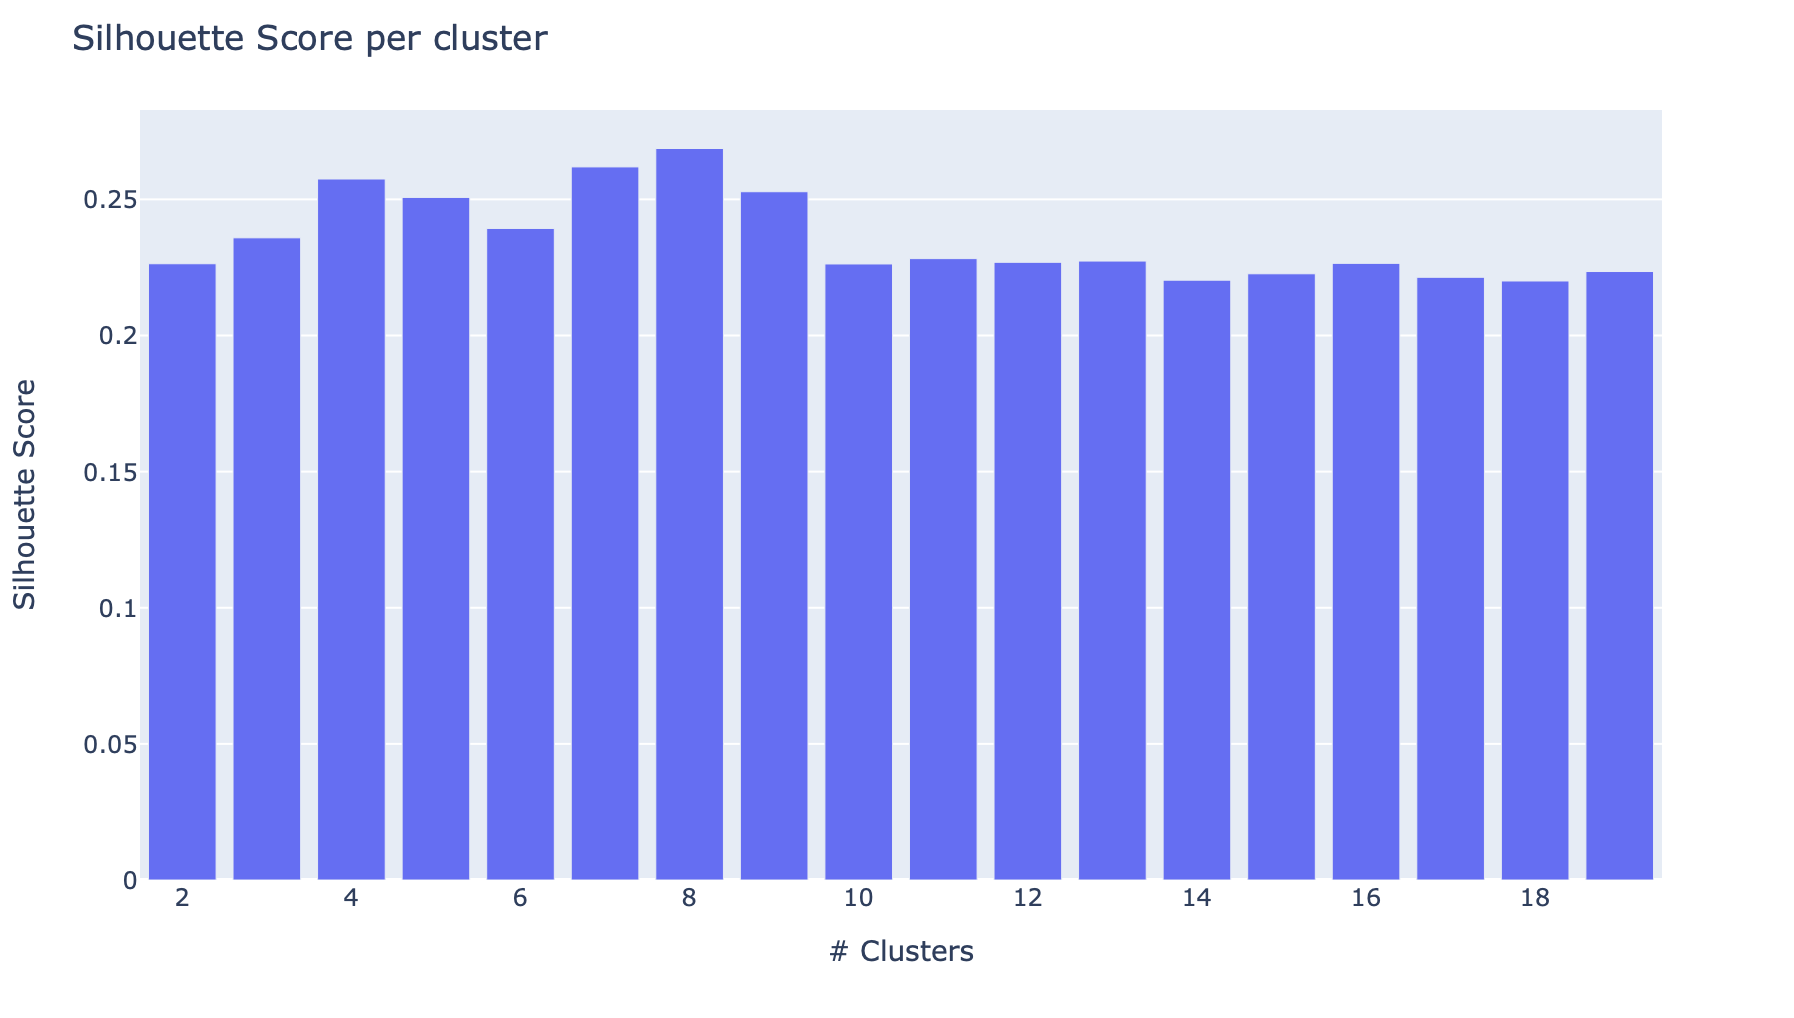

In [16]:
display(Image(filename='img/2.png'))

In [17]:
# 5 is the best number of clusters
kmeans = KMeans(n_clusters=5, random_state=0, init="k-means++")
kmeans.fit(df_clustering)

KMeans(n_clusters=5, random_state=0)

In [18]:
df_s['cluster_kmeans'] = kmeans.labels_
df_s["cluster_kmeans"] = df_s["cluster_kmeans"].astype(str)

In [19]:
df_s.head()

Lat      Lon  day_of_week  time_hour cluster_kmeans
567915  40.7555 -73.9758            1         16              0
895170  40.7552 -73.9674            3         12              1
454935  40.7391 -73.9869            0         17              0
316550  40.7332 -73.9902            0          6              1
474563  40.7200 -73.9885            1         20              0

In [20]:
#Map of the clusters
fig = px.scatter_mapbox(df_s,
                        lat="Lat",
                        lon="Lon",
                        color="cluster_kmeans",
                        color_discrete_map={"0": "rgb(0,0,0)", "1": "rgb(255,20,20)"},
                        opacity = 0.5,
                        mapbox_style="carto-positron",
                        zoom=10)
fig.show()

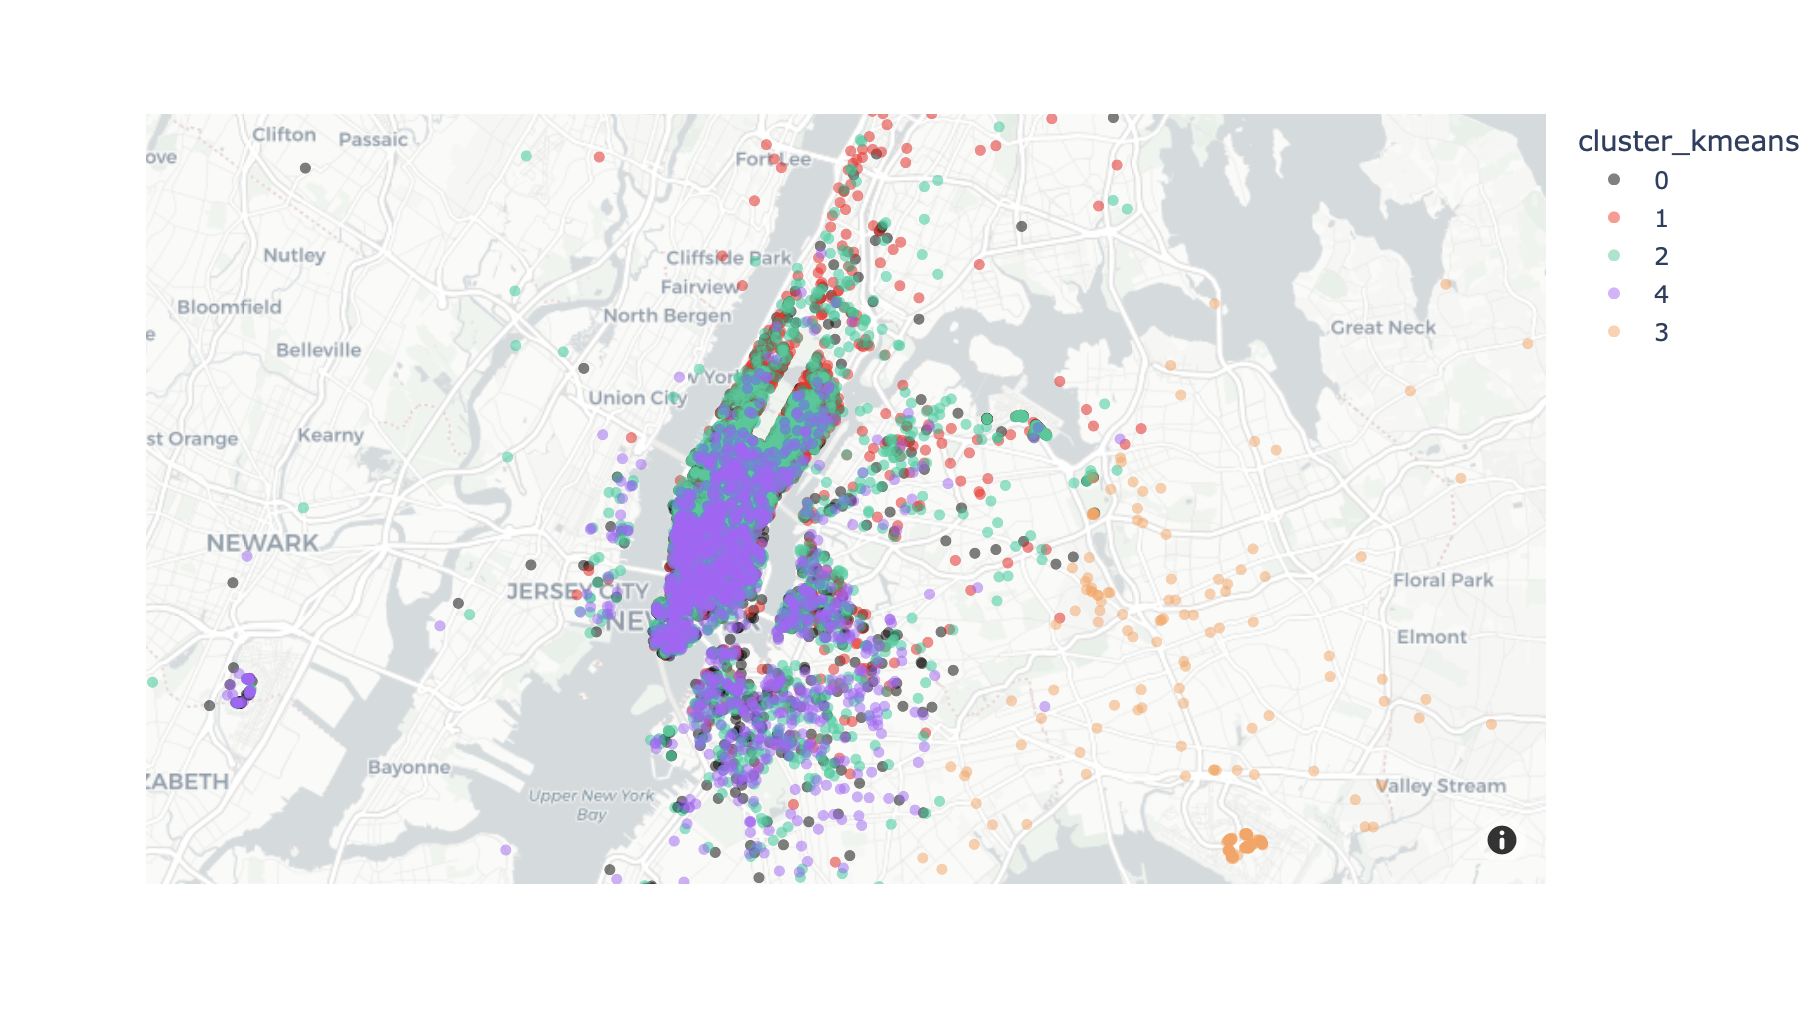

In [21]:
display(Image(filename='img/3.png'))

In [22]:
# day_of_week as integer to explicit day_of_week_name
df_s['day_of_week_name'] = df_s['day_of_week'].apply(lambda x :
                                                      "monday" if x == 0 else
                                                      "tuesday" if x == 1 else
                                                      "wednesday" if x == 2 else
                                                      "Thursday" if x == 3 else
                                                      "friday" if x == 4 else
                                                      "saturday" if x == 5 else
                                                      "sunday")

In [23]:
#Map of the clusters for each day of the week
fig = px.scatter_mapbox(df_s,
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'day_of_week_name',
                        animation_group = 'day_of_week_name', 
                        category_orders={"day_of_week_name": [0,1,2,3,4,5,6]},
                        color="cluster_kmeans",
                        color_discrete_map={"0": "rgb(0,0,0)", "1": "rgb(255,20,20)"}, 
                        mapbox_style="carto-positron", zoom=10)
fig.show()

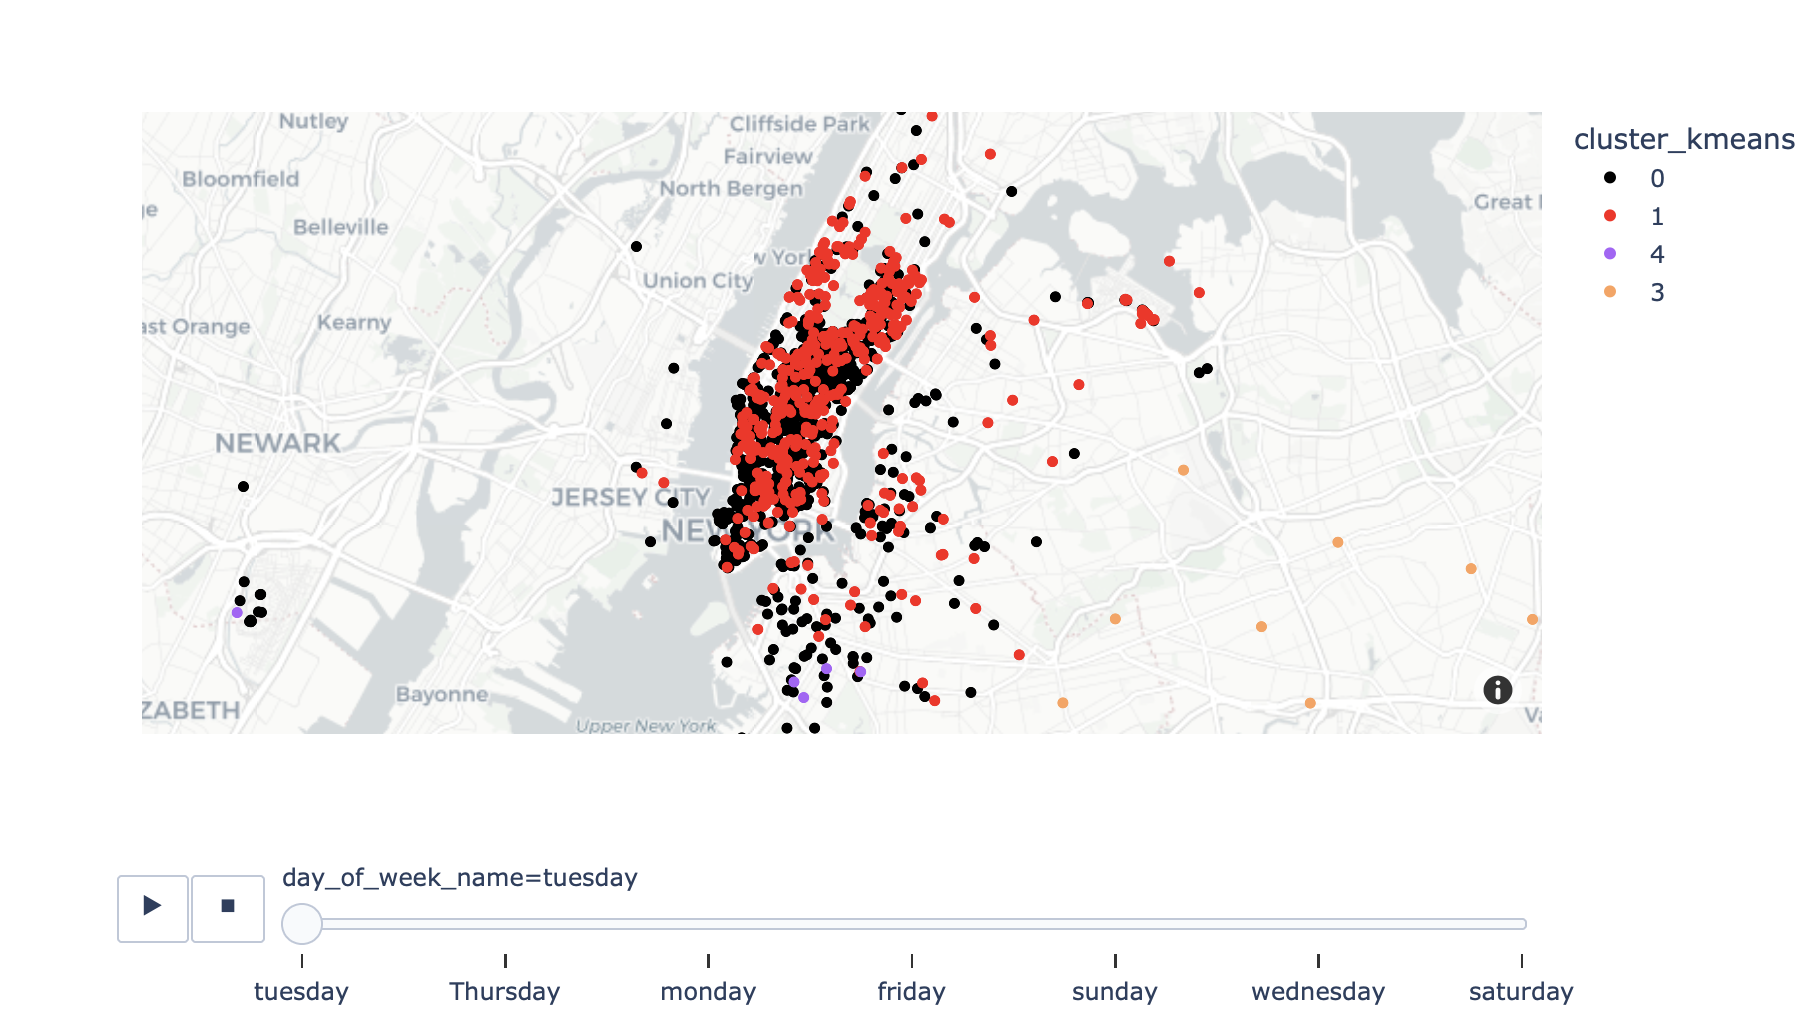

In [24]:
display(Image(filename='img/4.png'))

### 2 - DBscan method

In [25]:
dbscan = DBSCAN(eps=0.5, min_samples=150)
dbscan.fit(df_clustering)

DBSCAN(min_samples=150)

In [26]:
dbscan.labels_

array([ 0,  2,  5, ..., -1,  3, -1])

In [27]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [28]:
df_s["cluster_dbscan"] = dbscan.labels_

In [29]:
#Remove of outliers
mask = df_s['cluster_dbscan'] >= 0
df_s["cluster_dbscan"] = df_s["cluster_dbscan"].astype(str)

In [30]:
#Map of the clusters
fig = px.scatter_mapbox(df_s.loc[mask,:],
                        lat="Lat",
                        lon="Lon",
                        color="cluster_dbscan",
                        color_discrete_map={"0": "rgb(0,0,0)", "1": "rgb(255,20,20)"},
                        opacity = 0.5,
                        mapbox_style="carto-positron",
                        zoom=10)
fig.show()

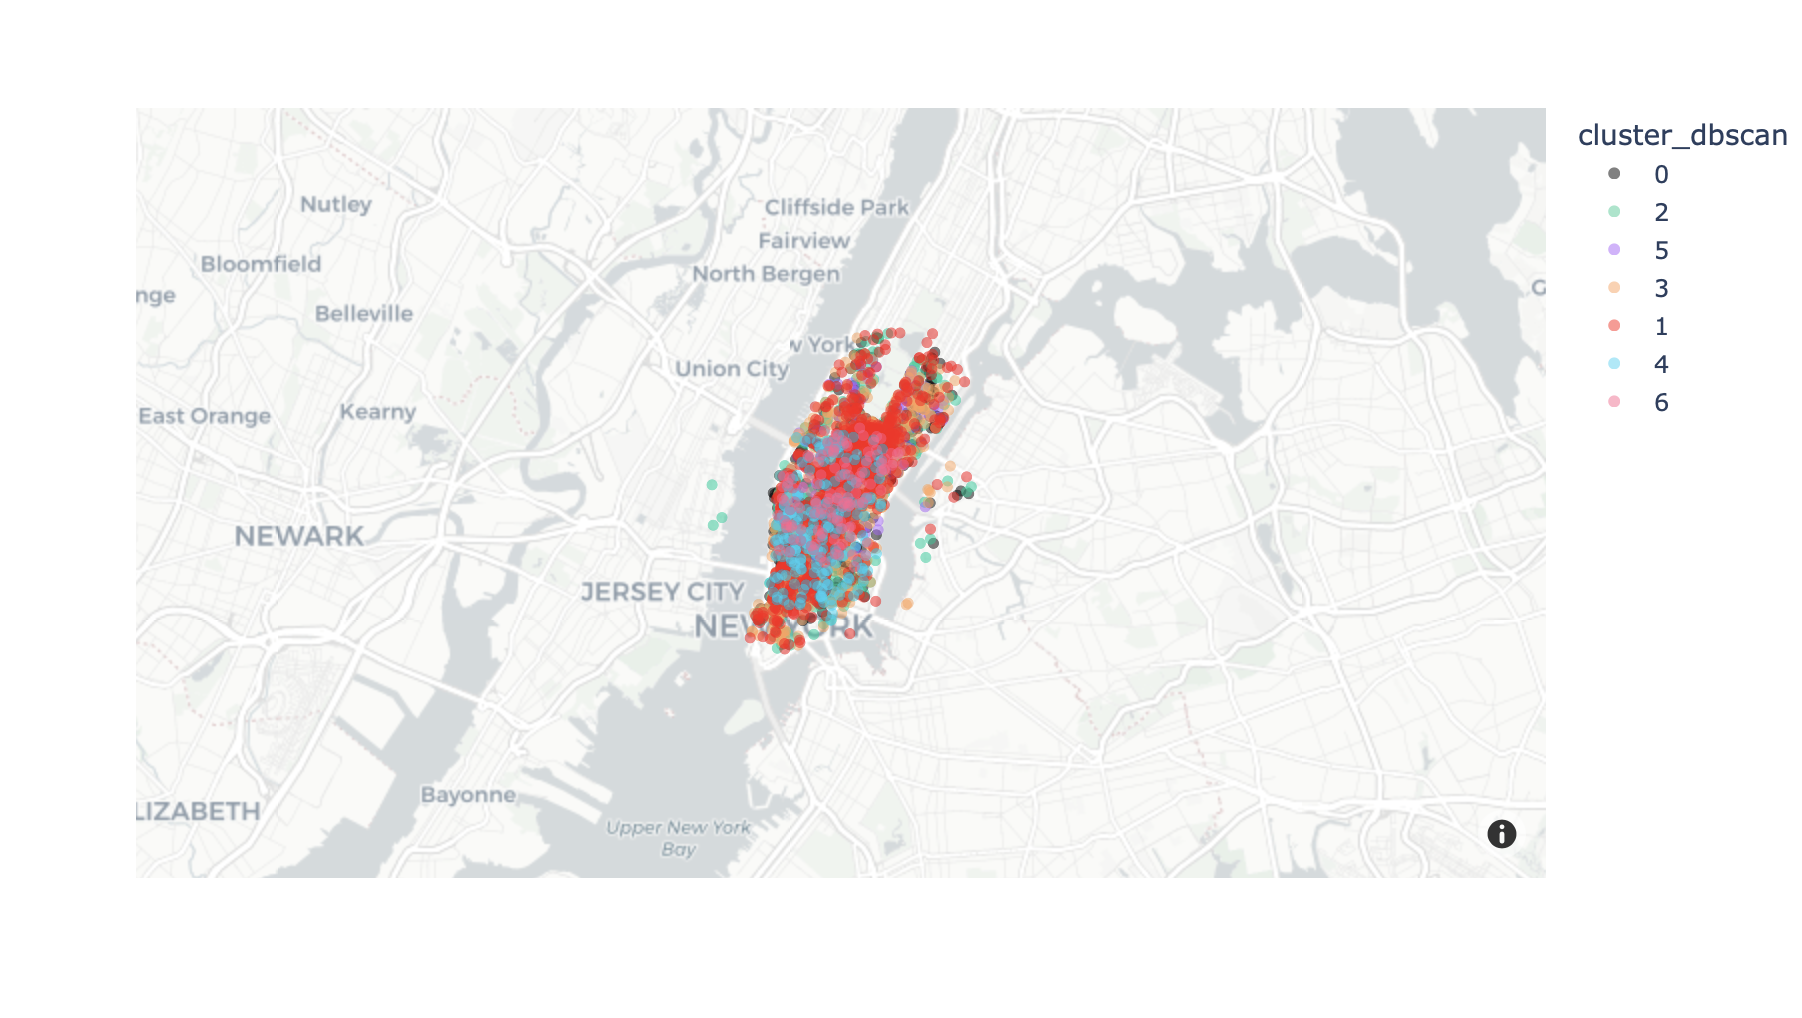

In [31]:
display(Image(filename='img/5.png'))

In [32]:
#Map of the clusters for each day of the week
fig = px.scatter_mapbox(df_s.loc[mask,:],
                        lat="Lat",
                        lon="Lon",
                        animation_frame = 'day_of_week_name',
                        animation_group = 'day_of_week_name', 
                        category_orders={"day_of_week_name": [0,1,2,3,4,5]},
                        color="cluster_dbscan",
                        color_discrete_map={"0": "rgb(0,0,0)", "1": "rgb(255,20,20)"}, 
                        mapbox_style="carto-positron", zoom=10)
fig.show()

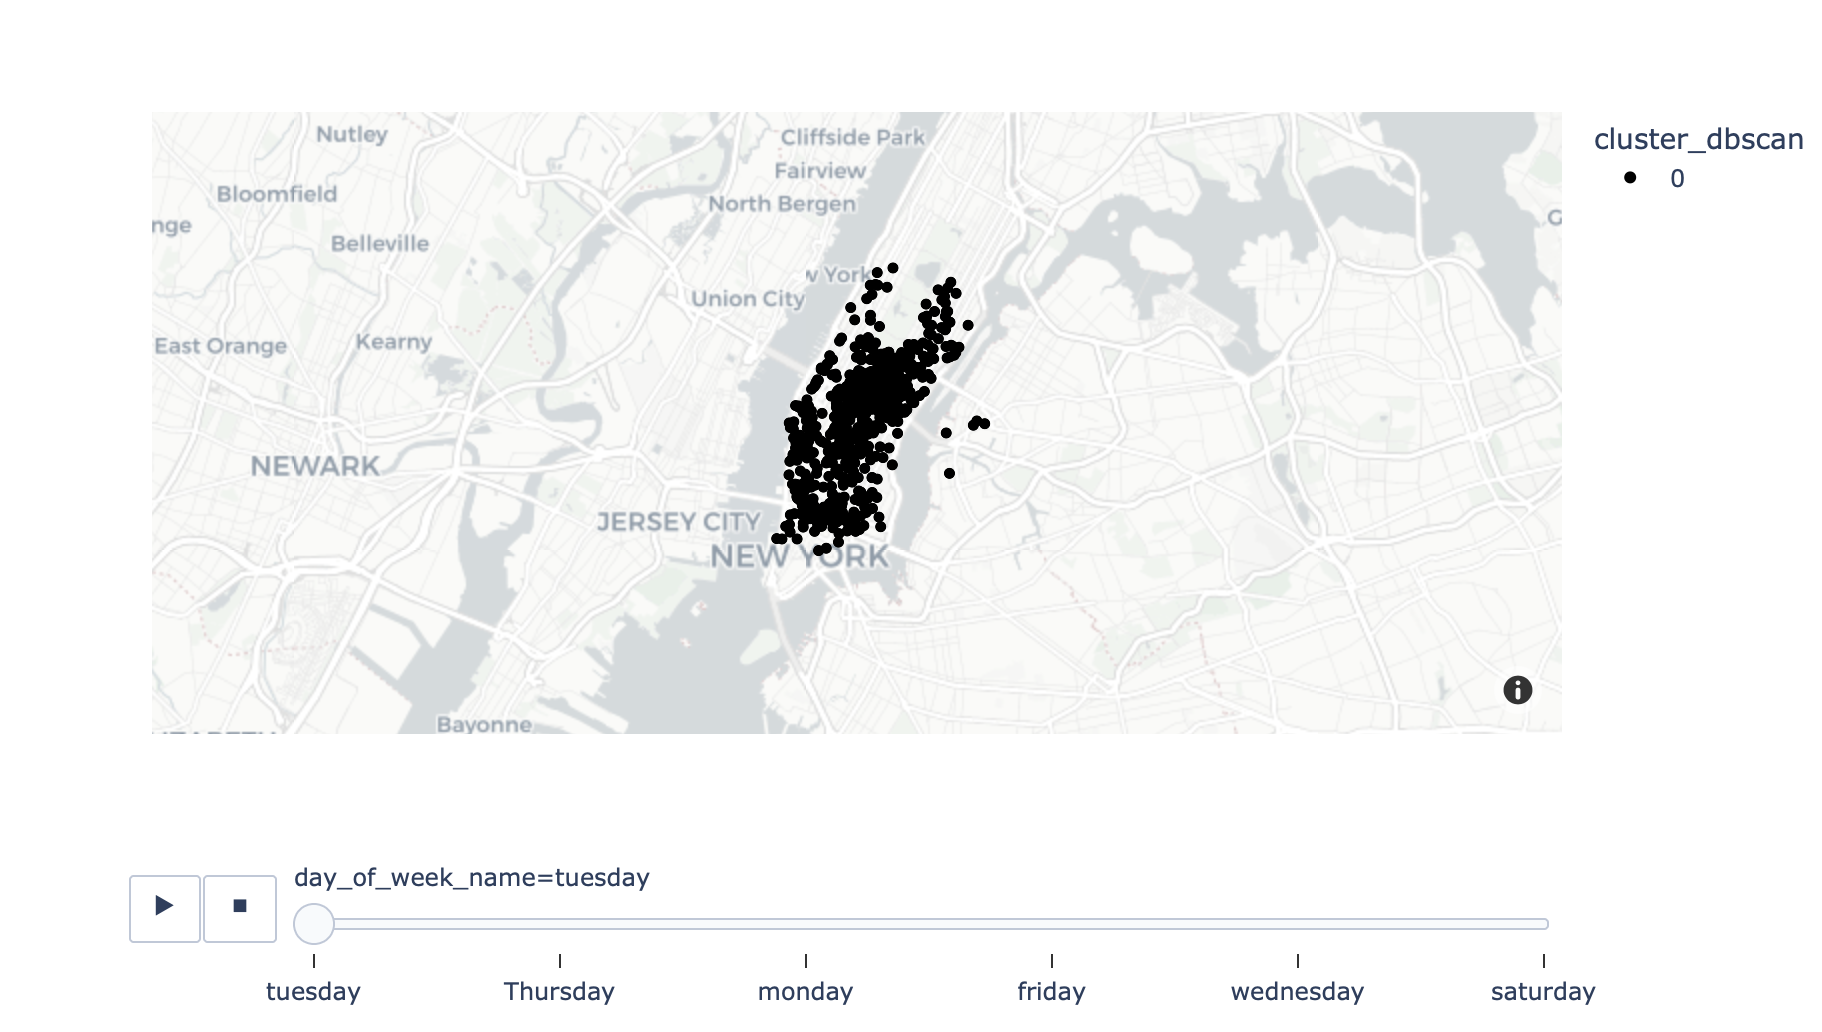

In [33]:
display(Image(filename='img/6.png'))